<a href="https://colab.research.google.com/github/ShovalBenjer/phantom-reach/blob/main/models_comparasion_webcam_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install mediapipe opencv-python-headless tensorflow numpy pandas matplotlib psutil
!pip install tensorflow tensorflow-hub

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode
import PIL
import io
import html
import time
import psutil

In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

def js_to_image(js_reply):
  """
  Params:
    js_reply: JavaScript object containing image from webcam
  Returns:
    RGB numpy array containing the image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into image
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "user" }});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here to stop camera</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return js_to_image(data['img'])

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''

<IPython.core.display.Javascript object>

In [13]:
class MetricsTracker:
    def __init__(self):
        self.inference_times = []
        self.cpu_usage = []
        self.memory_usage = []

    def start_inference(self):
        self.start_time = time.perf_counter()

    def end_inference(self):
        end_time = time.perf_counter()
        inference_time = (end_time - self.start_time) * 1000  # Convert to ms
        self.inference_times.append(inference_time)
        self.cpu_usage.append(psutil.cpu_percent())
        self.memory_usage.append(psutil.Process().memory_info().rss / 1024 / 1024)

    def get_metrics(self):
        return {
            "avg_inference_time": np.mean(self.inference_times),
            "avg_cpu_usage": np.mean(self.cpu_usage),
            "avg_memory_usage": np.mean(self.memory_usage)
        }

In [14]:
class MediaPipePoseEstimator:
    def __init__(self):
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=1,
            min_detection_confidence=0.5
        )
        self.mp_draw = mp.solutions.drawing_utils

    def predict(self, frame):
        results = self.pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.pose_landmarks:
            self.mp_draw.draw_landmarks(
                frame,
                results.pose_landmarks,
                self.mp_pose.POSE_CONNECTIONS
            )
        return results.pose_landmarks

In [31]:
class PoseNetEstimator:
    def __init__(self):
        import tensorflow as tf
        import tensorflow_hub as hub

        # Load the PoseNet model
        self.model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
        self.movenet = self.model.signatures['serving_default']

    def predict(self, frame):
        import tensorflow as tf

        # Prepare the image
        img = frame.copy()

        # Convert to RGB if needed
        if len(img.shape) == 3 and img.shape[2] == 3:
            input_img = img
        else:
            input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize and add batch dimension
        input_img = tf.cast(tf.image.resize_with_pad(input_img, 192, 192), dtype=tf.int32)
        input_img = tf.expand_dims(input_img, axis=0)

        # Run inference
        results = self.movenet(input_img)
        keypoints = results['output_0'].numpy()[0]

        # Draw keypoints
        y, x, _ = frame.shape
        for kp in keypoints:
            ky, kx, kp_conf = kp
            if kp_conf > 0.3:  # Confidence threshold
                cx = int(kx * x)
                cy = int(ky * y)
                cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)

        return keypoints

In [28]:
def run_comparison(num_frames=10):
    models = {
        "MediaPipe": MediaPipePoseEstimator(),
        "PoseNet": PoseNetEstimator(),
    }

    results = {}

    for model_name, model in models.items():
        print(f"Testing {model_name}...")
        metrics = MetricsTracker()

        for i in range(num_frames):
            try:
                frame = video_frame(label_html, bbox)

                metrics.start_inference()
                predictions = model.predict(frame)
                metrics.end_inference()

                # Display frame
                cv2_imshow(frame)
                output.clear()

                if i % 2 == 0:
                    print(f"Processed {i+1}/{num_frames} frames")

            except Exception as e:
                print(f"Error processing frame: {e}")
                continue

        results[model_name] = metrics.get_metrics()

    return pd.DataFrame(results).T

In [20]:
def plot_results(results_df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    results_df['avg_inference_time'].plot(kind='bar', ax=ax1)
    ax1.set_title('Average Inference Time (ms)')
    ax1.set_ylabel('Milliseconds')

    results_df['avg_cpu_usage'].plot(kind='bar', ax=ax2)
    ax2.set_title('Average CPU Usage (%)')
    ax2.set_ylabel('Percentage')

    results_df['avg_memory_usage'].plot(kind='bar', ax=ax3)
    ax3.set_title('Average Memory Usage (MB)')
    ax3.set_ylabel('Megabytes')

    plt.tight_layout()
    plt.show()

Testing PoseNet...
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)
Error processing frame: too many values to unpack (expected 3)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


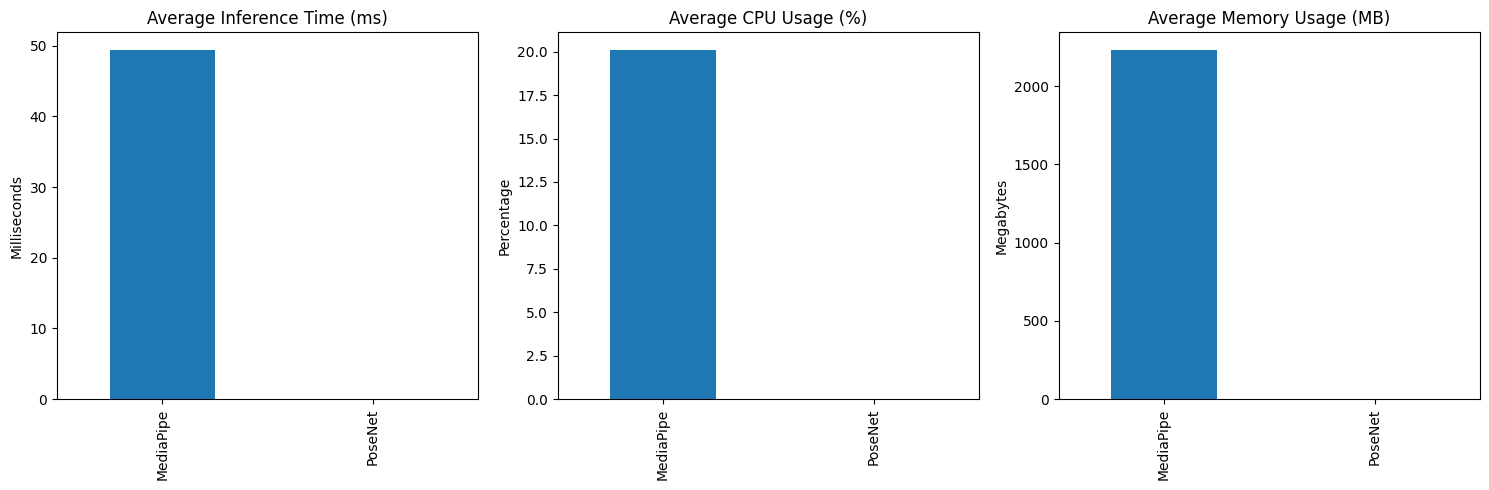

In [32]:
# Initialize video stream
video_stream()
time.sleep(3)  # Give time for webcam to initialize

# Run comparison
try:
    results = run_comparison(num_frames=10)
    plot_results(results)
except Exception as e:
    print(f"Error during comparison: {e}")